In [4]:
import sys
import os
current_dir = os.path.abspath('')  # 获取当前目录的绝对路径
parent_dir = os.path.dirname(current_dir)  # 获取父目录
sys.path.append(parent_dir)  # 添加父目录到 Python 路径
sys.path.append(parent_dir + '\\scripts')

from auto_plot import *

print("Current directory:", current_dir)
print("Parent directory:", parent_dir)

%load_ext autoreload
%aimport source, vis, pinn
%autoreload 1
%aimport

import source, auto_plot, vis, pinn

Current directory: d:\Git\PINN-LiDAR\sample
Parent directory: d:\Git\PINN-LiDAR
Modules to reload:
pinn source vis

Modules to skip:



### The structure of the DeepONet

- It's aim to train the network seprately, the branch network aim to capture the general information which is the mapping principle of the function in Banach space, however the Trunk provide the associate positional informatioin to make sure the rest of the information can be exptracted to there.

- Question, Can we impose a rule to the Branch network to force it convergence? which might cause a shorter training time.

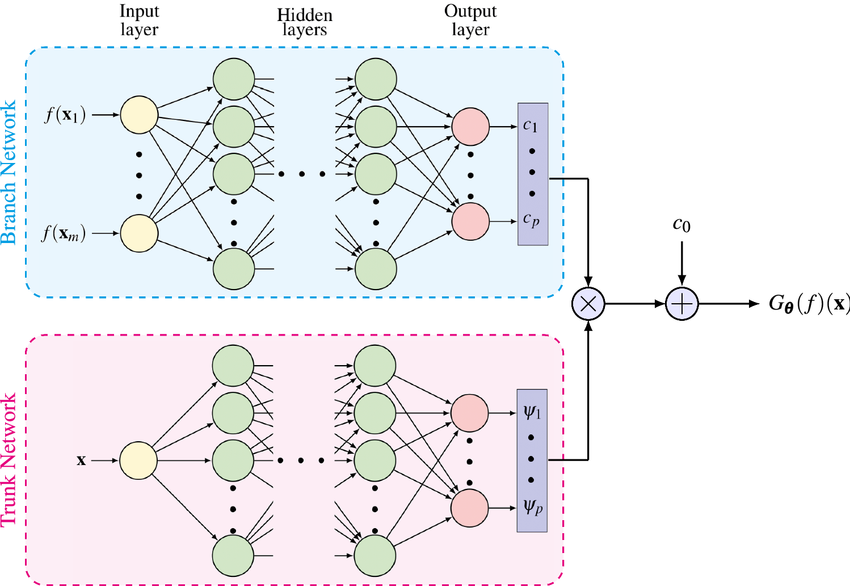

Compiling model...
'compile' took 0.000999 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.24e-02]    [5.19e-02]    [1.63e+00]    


C:\Users\1ieng\AppData\Local\Temp\ipykernel_17264\3479384908.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  result[outside] = source_strength * source_radius**2 * np.pi/2 * H0/4


1000      [2.04e-02]    [2.58e-02]    [9.83e-01]    
2000      [1.97e-02]    [2.46e-02]    [1.04e+00]    
3000      [1.98e-02]    [2.49e-02]    [1.03e+00]    
4000      [1.92e-02]    [2.39e-02]    [1.09e+00]    
5000      [1.74e-02]    [2.12e-02]    [1.53e+00]    
6000      [1.66e-02]    [2.03e-02]    [1.60e+00]    
7000      [1.47e-02]    [1.83e-02]    [2.00e+00]    
8000      [1.37e-02]    [1.70e-02]    [2.34e+00]    
9000      [1.36e-02]    [1.69e-02]    [2.28e+00]    
10000     [1.03e-02]    [1.23e-02]    [2.08e+00]    
11000     [6.20e-03]    [7.57e-03]    [1.87e+00]    
12000     [3.38e-03]    [4.19e-03]    [1.96e+00]    
13000     [2.67e-03]    [3.32e-03]    [2.23e+00]    
14000     [2.44e-03]    [3.07e-03]    [2.45e+00]    
15000     [2.33e-03]    [2.96e-03]    [2.52e+00]    
16000     [2.61e-03]    [3.42e-03]    [2.57e+00]    
17000     [2.21e-03]    [2.87e-03]    [2.58e+00]    
18000     [2.20e-03]    [2.91e-03]    [2.58e+00]    
19000     [2.06e-03]    [2.76e-03]    [2.61e+0

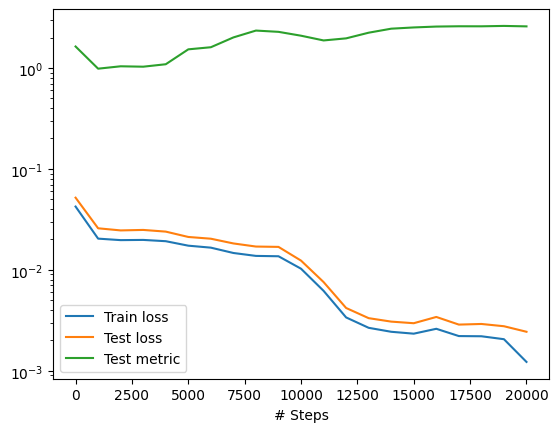

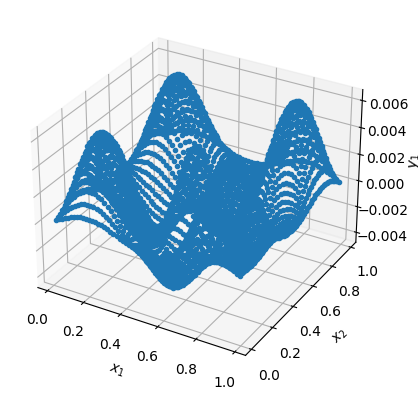

In [ ]:
import deepxde as dde
import numpy as np
import torch

# General parameters
n = 2
precision_train = 10
precision_test = 30
hard_constraint = True
iterations = 20000
parameters = [1e-3, 3, 150, "sin"]

# Define sine function
sin = dde.backend.sin

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters

# Spherical source parameters
x0, y0 = 0.5, 0.5  # 源中心位置
source_radius = 0.1  # 源的半径
source_strength = 1.0  # 源强度

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    if dde.backend.backend_name == "jax":
        y = y[0]
        dy_xx = dy_xx[0]
        dy_yy = dy_yy[0]

    # 计算到源中心的距离
    r = torch.sqrt((x[:, 0:1] - x0)**2 + (x[:, 1:2] - y0)**2)
    
    # 创建球形源：在半径内均匀分布，半径外为0
    # 使用平滑过渡来避免数值不稳定性
    transition_width = 0.01
    source = source_strength * 0.5 * (1 - dde.backend.tanh((r - source_radius)/transition_width))
    
    return -dy_xx - dy_yy - k0**2 * y - source

def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y

def boundary(_, on_boundary):
    return on_boundary

# 定义计算域和波数
geom = dde.geometry.Rectangle([0, 0], [1, 1])
k0 = 2 * np.pi * n
wave_len = 1 / n

# 计算训练和测试点的数量
hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)
num_domain = nx_train**2

# 设置边界条件
if hard_constraint == True:
    bc = []
else:
    bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)


from scipy.special import hankel1, j0

def func(x):
    """
    二维亥姆霍兹方程球形源的解析解
    使用零阶汉克尔函数描述向外辐射的圆柱波
    """
    # 计算观察点到源中心的距离
    r = np.sqrt((x[:, 0:1] - x0)**2 + (x[:, 1:2] - y0)**2)
    
    # 对于r < source_radius的区域（源内部）
    inside = r <= source_radius
    outside = r > source_radius
    
    result = np.zeros_like(r)
    
    # 源内部的解
    if np.any(inside):
        r_in = r[inside]
        result[inside] = source_strength/(k0**2) * (1 - j0(k0 * r_in))
    
    # 源外部的解
    if np.any(outside):
        r_out = r[outside]
        # 使用汉克尔函数描述向外辐射的波
        # 注意：这里使用的是第一类汉克尔函数 H_0^(1)
        H0 = hankel1(0, k0 * r_out)
        result[outside] = source_strength * source_radius**2 * np.pi/2 * H0/4
        
    return result.reshape(-1, 1)

# 修改原代码中的data定义部分
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=num_domain,
    num_boundary=4 * nx_train,
    num_test=nx_test**2,
    solution=func,  # 添加解析解
)

# 构建神经网络
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

if hard_constraint == True:
    net.apply_output_transform(transform)

# 编译模型
model = dde.Model(data, net)

if hard_constraint == True:
    model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
else:
    loss_weights = [1, 100]  # 增加边界条件的权重
    model.compile(
        "adam",
        lr=learning_rate,
        metrics=["l2 relative error"],
        loss_weights=loss_weights,
    )
    
save_dir = "model"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, "checkpoint.ckpt")


checker = dde.callbacks.ModelCheckpoint(
    model_path,
    save_better_only=True,  # 只保存更好的模型
    period=10000  # 每1000步保存一次
)

# 训练模型
losshistory, train_state = model.train(
    iterations=iterations,
    callbacks=[checker],
    model_save_path="model/final.ckpt"  # 这里设置保存路径
)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

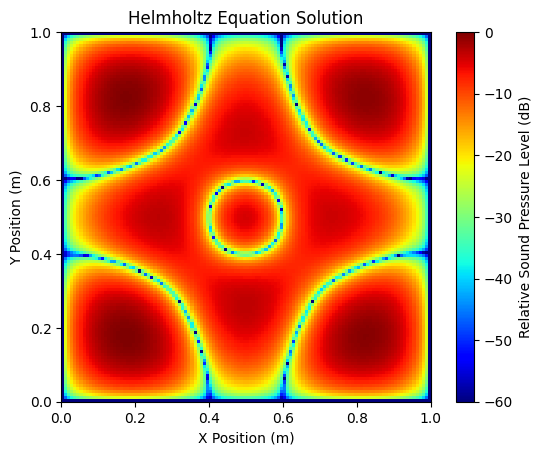

In [14]:
from vis import Avis

def plot_helmholtz_spl(model, train_state, nx=120, ny=120):
    """
    将train_state的结果转换为SPL热图
    nx, ny: 网格点数
    """
    # 创建均匀网格
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    
    # 准备预测点
    points = np.vstack((X.flatten(), Y.flatten())).T
    
    # 使用训练好的模型进行预测
    sp = model.predict(points)
    
    # 重塑为网格形状
    sp = sp.reshape(nx, ny)
    
    # 使用您的绘图函数
    Avis.plot_spl_heatmap(sp, X, Y, "Helmholtz Equation Solution", db_range=(-60, 0))
    plt.show()

model.restore('model/checkpoint.ckpt-14000.pt')
plot_helmholtz_spl(model, train_state)